## CHAAYA GIRIMON GH1027231

### PROBLEM STATEMENT:
The company has historical data with handwritten records and would like to digitize these records. Hence it is important to recognize handwritten characters accurately for improving data efficieny and reducing manual errors (Rosebrock, A. (2020)). 

This helps the company by automating document processing and helps in making data retrieval faster and more reliable.

### DATASET:
datasets can be found at: 
https://www.kaggle.com/datasets/landlord/handwriting-recognition/code
https://www.kaggle.com/datasets/vaibhao/handwritten-characters

In [1]:
import random
import matplotlib.pyplot as plt
import os
import cv2

import numpy as np
import pandas as pd
import imutils
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.layers import Dense, Activation, Flatten, Dense, MaxPooling2D, Dropout, Conv2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator

2024-07-04 19:24:34.424978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
img_size = 32 # reducing img size to prevent overloading
non_chars = ["#","$","&","@"] # dataset has these non-characters which are not required hence will be removed

In [3]:
def get_data(dir_,len_):
    temp = []
    for i in os.listdir(dir_):
        if i in non_chars:
            continue
        count = 0
        sub_directory = os.path.join(dir_,i)
        for j in os.listdir(sub_directory):
            count+=1
            if count > len_:
                break
            img = cv2.imread(os.path.join(sub_directory,j),0)
            img = cv2.resize(img,(img_size,img_size))
            temp.append([img,i])
            
    return temp

# use incase .DS_Store appears in the directory
# try:
# except NotADirectoryError as err:
#     print(str(err).split(":")[1].replace("'","").replace(" ",""))
#     os.remove(str(err).split(":")[1].replace("'","").replace(" ",""))

In [4]:
# getting 4000 and 1000 images respectively so as to not overload the model
# laptop overheating
train_dir = "archive-1/Train/"
val_dir = "archive-1/Validation"
train_data = get_data(train_dir, 4000)
val_data = get_data(val_dir, 1000)

In [5]:
len(train_data)

140000

In [6]:
len(val_data)

15209

### DATA PREPROCESSING:

In [7]:
train_X = [features for features, label in train_data]
train_Y = [label for features, label in train_data]
val_X = [features for features, label in val_data]
val_Y = [label for features, label in val_data]

train_X[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [9]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [10]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [11]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [12]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


### EDA (EXPLORATORY DATA ANALYSIS)

**Displaying a random character from the dataset**

In [13]:
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])

print(f"Training Data: {train_df.shape}")
print(f"Validation Data: {val_df.shape}")

Training Data: (140000, 2)
Validation Data: (15209, 2)


In [14]:
train_df.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 1,...",R
1,"[[2, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,...",R
2,"[[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0,...",R
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,...",R
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2,...",R


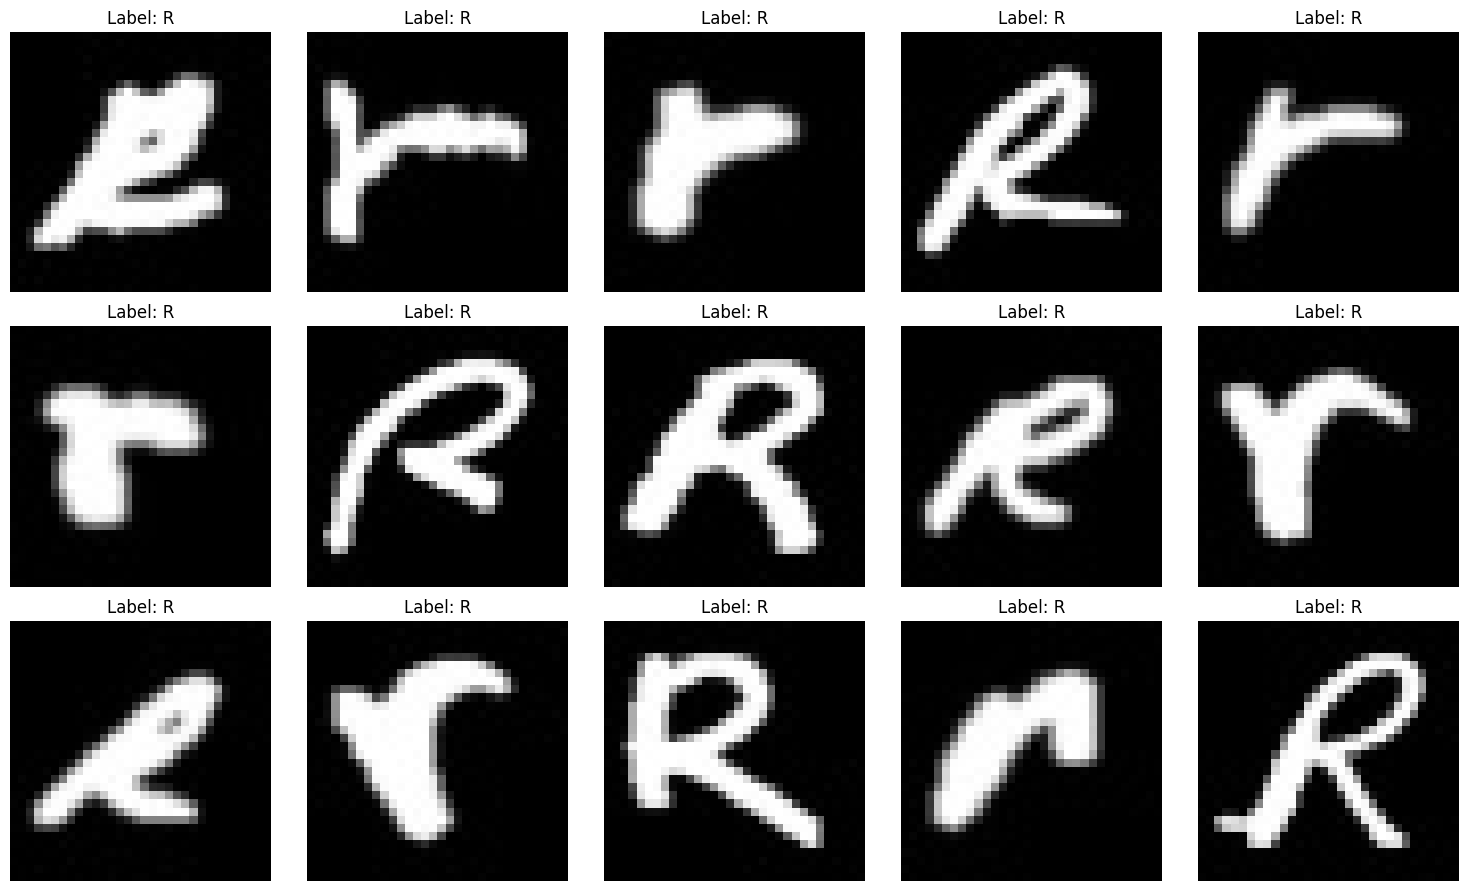

In [15]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(15):
    img = train_df.iloc[i]['image']
    label = train_df.iloc[i]['label']
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Distribution of the data**

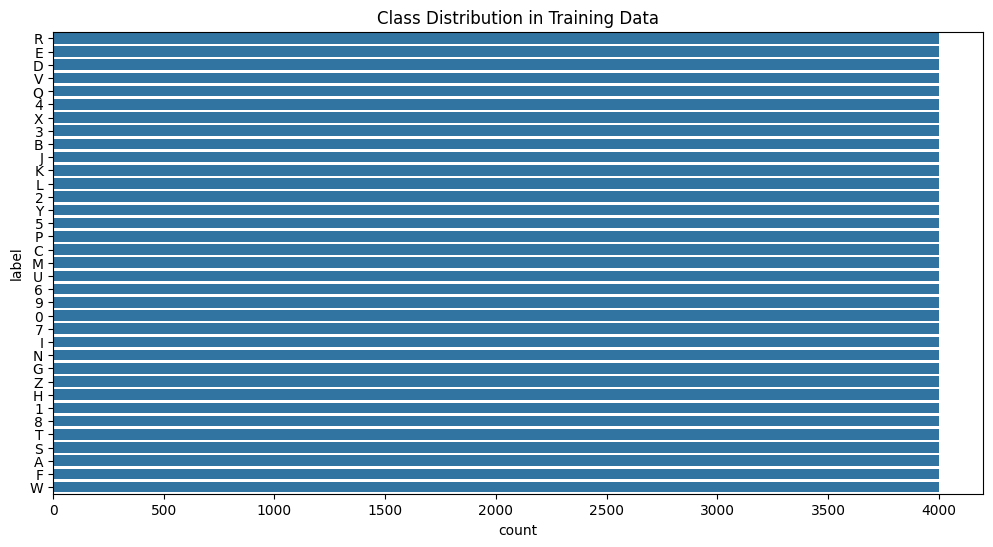

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index)
plt.title("Class Distribution in Training Data")
plt.show()

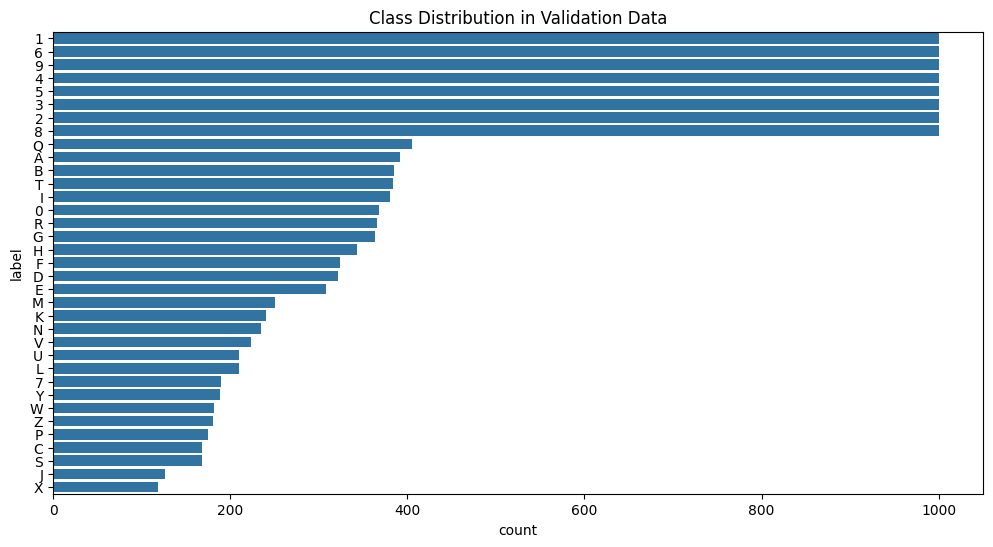

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(y=val_df['label'], order=val_df['label'].value_counts().index)
plt.title("Class Distribution in Validation Data")
plt.show()

In [18]:
def create_model(filters=[32, 64, 128], dense_units=256, dropout_rate=0.5, learning_rate=0.001):
#     print("function called")
#     print(filters, dense_units, dropout_rate, learning_rate)
    model = Sequential()
    model.add(Conv2D(filters[0], (3, 3), padding="same", activation='relu', input_shape=(img_size, img_size, 1)))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for filter_size in filters[1:]:
        model.add(Conv2D(filter_size, (3, 3), activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(LB.classes_), activation='softmax'))
    
#     optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [19]:
# Hyperparameter configurations
configurations = [
    {"filters": [32, 64, 128], "dense_units": 256, "dropout_rate": 0.5, "learning_rate": 0.001},
    {"filters": [64, 128, 256], "dense_units": 512, "dropout_rate": 0.5, "learning_rate": 0.001},
    {"filters": [32, 64], "dense_units": 128, "dropout_rate": 0.25, "learning_rate": 0.001},
    {"filters": [64, 128, 256], "dense_units": 256, "dropout_rate": 0.3, "learning_rate": 0.001},
    {"filters": [32, 64, 128], "dense_units": 256, "dropout_rate": 0.5, "learning_rate": 0.0001},
    {"filters": [64, 128], "dense_units": 256, "dropout_rate": 0.4, "learning_rate": 0.001},
    {"filters": [32, 64, 128], "dense_units": 128, "dropout_rate": 0.25, "learning_rate": 0.001},
    {"filters": [32, 64, 128], "dense_units": 256, "dropout_rate": 0.5, "learning_rate": 0.0005},
    {"filters": [64, 128, 256], "dense_units": 512, "dropout_rate": 0.5, "learning_rate": 0.0005},
    {"filters": [32, 64], "dense_units": 128, "dropout_rate": 0.3, "learning_rate": 0.0005},
]


In [20]:
# Store results
results = []

# Perform training with different configurations
# early stopping reduces accuracy. Remove in main model
for config in configurations:
    model = create_model(**config)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     print(val_X[0],"GGG",val_Y[0],"GGG", train_X[0])
    history = model.fit(
        train_X,train_Y,
        validation_data=(val_X, val_Y),
        epochs=50,
        steps_per_epoch=len(train_X) // 32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    y_pred = model.predict(val_X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_Y, axis=1)
    
    accuracy = np.mean(y_pred_classes == y_true_classes)
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    results.append({
        "config": config,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    })

476/476 [==============================] - 6s 12ms/step


In [21]:
# Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="accuracy", ascending=False)
print(results_df)

                                              config  accuracy  precision  \
8  {'filters': [64, 128, 256], 'dense_units': 512...  0.936156   0.937448   
7  {'filters': [32, 64, 128], 'dense_units': 256,...  0.930041   0.932369   
6  {'filters': [32, 64, 128], 'dense_units': 128,...  0.929713   0.931782   
3  {'filters': [64, 128, 256], 'dense_units': 256...  0.929318   0.932803   
0  {'filters': [32, 64, 128], 'dense_units': 256,...  0.927872   0.930105   
2  {'filters': [32, 64], 'dense_units': 128, 'dro...  0.927543   0.928025   
9  {'filters': [32, 64], 'dense_units': 128, 'dro...  0.927346   0.929937   
1  {'filters': [64, 128, 256], 'dense_units': 512...  0.926688   0.928214   
4  {'filters': [32, 64, 128], 'dense_units': 256,...  0.925833   0.928182   
5  {'filters': [64, 128], 'dense_units': 256, 'dr...  0.922020   0.928688   

     recall  f1_score  
8  0.936156  0.935953  
7  0.930041  0.929976  
6  0.929713  0.929998  
3  0.929318  0.929658  
0  0.927872  0.927902  
2  0.927

### RESULTS:
Eventhough number 8 and 7 are better in results, number 6 is chosen as it is less intensive compared to the others.